<a href="https://colab.research.google.com/github/chantel808/Springboard_Capstone1/blob/master/Stats_google_health_search_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Statistical Analysis of Google Health Searches#
Dataset is located at: https://www.kaggle.com/GoogleNewsLab/health-searches-us-county 
. Make sure to downloaded and unzip the data.

The statistical analyses used in this project include:
 1. descriptive statistics of the Google Health search data including count, maximum, minimum, quartiles, mean
 2. a correlation matrix to determine if the mean interest scores for various health queries are correlated, and
 3. student t-test to compare the score means




In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import requests
import zipfile
import io
from scipy.stats import sem
from scipy.stats import t
from scipy.stats import ttest_ind

In [2]:
# install watermark extension
!pip install watermark

%load_ext watermark

%watermark -a "Chantel Clark" -d -t -v -p numpy,pandas,scipy.stats

Chantel Clark 2020-03-06 01:55:35 

CPython 3.6.9
IPython 5.5.0

numpy 1.17.5
pandas 0.25.3
scipy.stats 1.4.1


This cell with open a window where you can select the data csv file you downloaded.

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving health_searches_cleaned.csv to health_searches_cleaned (1).csv
User uploaded file "health_searches_cleaned.csv" with length 87531 bytes


In [4]:
#file='RegionalInterestByConditionOverTime.csv'
file='health_searches_cleaned.csv'
healthSearchData=pd.read_csv(file)
healthSearchData = healthSearchData.drop(healthSearchData.columns[0], axis=1) # drop first unnamed column
healthSearchData.head()

,dma,2004+cancer,2004+cardiovascular,2004+stroke,2004+depression,2004+rehab,2004+vaccine,2004+diarrhea,2004+obesity,2004+diabetes,2005+cancer,2005+cardiovascular,2005+stroke,2005+depression,2005+rehab,2005+vaccine,2005+diarrhea,2005+obesity,2005+diabetes,2006+cancer,2006+cardiovascular,2006+stroke,2006+depression,2006+rehab,2006+vaccine,2006+diarrhea,2006+obesity,2006+diabetes,2007+cancer,2007+cardiovascular,2007+stroke,2007+depression,2007+rehab,2007+vaccine,2007+diarrhea,2007+obesity,2007+diabetes,2008+cancer,2008+cardiovascular,2008+stroke,...,2013+obesity,2013+diabetes,2014+cancer,2014+cardiovascular,2014+stroke,2014+depression,2014+rehab,2014+vaccine,2014+diarrhea,2014+obesity,2014+diabetes,2015+cancer,2015+cardiovascular,2015+stroke,2015+depression,2015+rehab,2015+vaccine,2015+diarrhea,2015+obesity,2015+diabetes,2016+cancer,2016+cardiovascular,2016+stroke,2016+depression,2016+rehab,2016+vaccine,2016+diarrhea,2016+obesity,2016+diabetes,2017+cancer,2017+cardiovascular,2017+stroke,2017+depression,2017+rehab,2017+vaccine,2017+diarrhea,2017+obesity,2017+diabetes,state_abbrev,region
0,Portland-Auburn ME,44,6,17,39,21,31,14,29,38,70,16,38,11,27,36,26,14,23,55,23,26,25,38,48,48,19,44,70,31,56,38,37,42,22,24,56,68,22,66,...,52,66,79,44,70,72,70,72,61,51,75,67,43,61,70,67,64,68,48,73,69,38,70,64,60,64,69,49,81,70,37,83,64,56,76,66,47,80,ME,Northeast
1,New York NY,47,6,13,38,16,33,12,27,32,63,15,35,10,22,29,23,15,19,49,18,18,20,26,38,37,22,33,64,29,43,34,36,41,18,26,48,64,18,48,...,44,58,71,33,45,53,58,57,56,39,62,64,36,44,55,53,58,56,46,63,68,41,47,53,51,64,57,49,77,70,34,53,56,53,79,56,52,78,NY,Northeast
2,Binghamton NY,48,3,16,50,12,37,24,31,37,62,8,44,13,25,21,23,24,18,54,19,26,27,20,35,34,30,26,61,20,56,43,28,45,25,43,54,65,15,62,...,52,70,80,36,63,74,50,66,75,65,72,64,31,59,69,46,73,84,67,75,74,33,66,66,44,72,79,70,74,68,24,71,69,44,77,78,61,72,NY,Northeast
3,Macon GA,44,14,14,37,19,49,14,29,31,55,25,48,10,29,33,22,23,22,44,24,23,18,39,50,46,29,39,65,42,54,35,40,42,16,36,48,66,23,58,...,62,64,72,56,69,60,71,53,68,54,78,66,60,62,68,66,53,71,60,73,63,59,65,56,69,56,66,51,78,53,38,62,46,60,47,53,41,66,GA,South
4,Philadelphia PA,52,7,16,41,23,36,14,30,37,73,17,39,12,32,33,24,18,23,57,24,23,23,40,42,44,24,40,72,34,49,38,46,47,21,31,55,75,23,59,...,51,68,81,39,57,62,83,68,66,44,70,71,45,51,63,77,69,67,56,72,74,42,56,59,72,70,70,52,80,75,35,61,62,75,84,69,56,78,PA,Northeast


In [0]:
# Check for null values
for col in healthSearchData.columns:
  bool_series = pd.isnull(healthSearchData[col])
  if len(healthSearchData[bool_series].index.values) != 0:
    print(healthSearchData[bool_series].index.values)

In [6]:
healthSearchData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Columns: 129 entries, dma to region
dtypes: int64(126), object(3)
memory usage: 211.8+ KB


In [7]:
"""
# Save and download the dataframe as csv file
healthSearchData.to_csv('health_searches_cleaned.csv')
files.download('health_searches_cleaned.csv')
"""

"\n# Save and download the dataframe as csv file\nhealthSearchData.to_csv('health_searches_cleaned.csv')\nfiles.download('health_searches_cleaned.csv')\n"

# Descriptive Statistics

In [8]:
healthSearchData.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
2004+cancer,210.0,43.904762,7.618944,27.0,40.0,43.0,47.0,100.0
2004+cardiovascular,210.0,7.433333,7.909647,0.0,5.0,6.0,9.0,100.0
2004+stroke,210.0,17.642857,8.135284,0.0,14.0,16.0,18.0,100.0
2004+depression,210.0,45.623810,13.715720,0.0,37.0,44.0,51.0,100.0
2004+rehab,210.0,18.890476,10.157723,0.0,15.0,17.0,21.0,100.0


The data here has a range of 0-100, and is described on Google Search API as an 'interest score'. Scores are proportional to the fraction of all searches, so a score of 100 represents very high interest, and a score of 50 is half as popular as the previous search. A score of 0 means that there was not enough data.

Caution must be used in interpreting this data; it is *not* possible to obtain the total count of searches because the scores are proportional. This means that a larger city with a score of 50 for a particular search such as 'cancer' would get a lower score than a smaller city where $\frac{3}{4}$ of searches were 'cancer' would get a score of 75. It is unclear from data source what the total search count is out of - is it of all Google searches, or just the searches that are in this dataset ('cancer', 'stroke', 'cardiovascular', 'diabetes', 'obesity', 'depression', 'vaccine', 'rehab', and 'diarrhea'). It is also ambiguous whether or not a search query such as 'diabetes' involves all variations of the query like 'Diabetes Type 1' or 'Diabetes Type 2', or does it strictly include queries with just the word 'diabetes'?

Because the data includes proportional health interest scores, the best way to use this data would be to look at relative increases and decreases in the interest scores. For example:
* Of the Google Health Search dataset, which health searches are the most and least popular?
* Which health queries have the largest change in mean search interest score from year to year, and over the span of 2004-2017?
* Are there differences in interest score between the four U.S. regions (Northeast, South, West, Midwest)?
* Are there any patterns in the regions which contain high outliers? 

This way, even if there were a larger volume of searches in the most recent years because of increased internet use, the mean score should not be greatly affected  by the increased volume of users. Realistically though, the increased access to internet for different types of users (of various ages and wealth classes) will influence the outcomes, and should be considered when interpreting the data.

In [0]:
# List of queries
queries = ['cancer', 'cardiovascular', 'stroke', 'depression', 'obesity', 'diabetes']

# Mean Search Interest Scores

As mentioned early, all zero scores were removed from the dataset when calculating the mean because a zero score did not represent very low interest, and there were not many zero scores. Scores of 100 were kept in the analysis because they represent a very high search interest score. 


In [0]:
# Remove zeros, and replace with nan
healthSearchData_nozeros = healthSearchData.replace(0, np.nan)

In [11]:
healthSearchData_nozeros.describe().T.head()

,count,mean,std,min,25%,50%,75%,max
2004+cancer,210.0,43.904762,7.618944,27.0,40.00,43.0,47.0,100.0
2004+cardiovascular,184.0,8.483696,7.905159,2.0,5.00,7.0,10.0,100.0
2004+stroke,208.0,17.812500,7.986609,8.0,14.75,16.0,18.0,100.0
2004+depression,209.0,45.842105,13.377972,20.0,37.00,44.0,51.0,100.0
2004+rehab,202.0,19.638614,9.618757,6.0,15.00,18.0,21.0,100.0


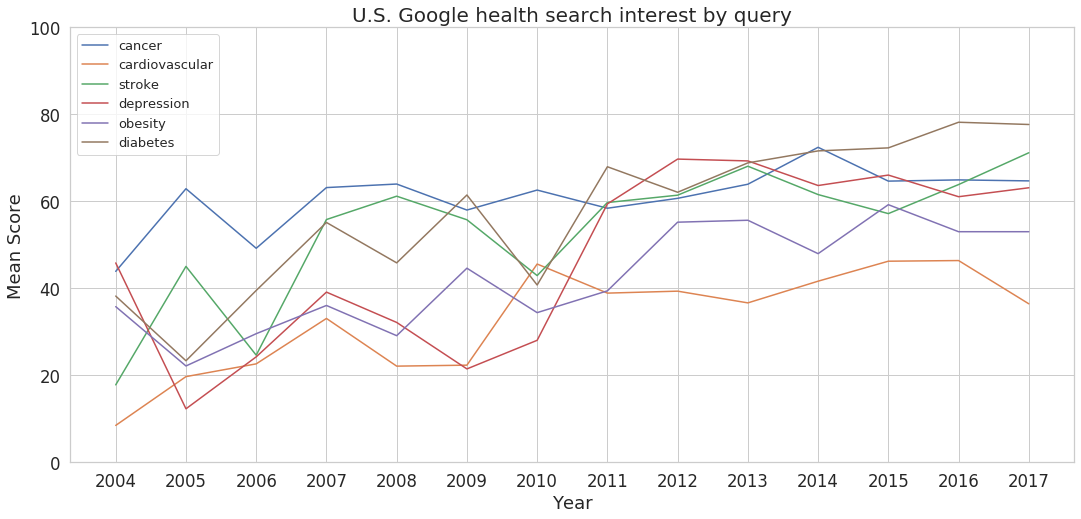

In [12]:
sns.set(font_scale=1.5)
sns.set_style("whitegrid")

# U.S. average for each query across years
yearMean = {}
for col in healthSearchData_nozeros.columns:
    if '+' in col:
        year = col.split('+')[0]
        disease = col.split('+')[-1]
        if not disease in yearMean:
            yearMean[disease] = {}
        if not year in yearMean[disease]:
            yearMean[disease][year] = np.nanmean(list(healthSearchData_nozeros[col])) # take the mean ingnoring NaN's

# Remove unwanted keys
rem_list = ['diarrhea', 'rehab', 'vaccine']
[yearMean.pop(key) for key in rem_list]

plt.figure(figsize=(18, 8))
ax = plt.subplot(111)
plt.ylim(0,100)
plt.title("U.S. Google health search interest by query", fontsize=20)
plt.xlabel('Year')
plt.ylabel('Mean Score')

ax.set_xticks(range(0,14))
ax.set_xticklabels(list(yearMean['cancer'].keys()))
lh = {} #dictionary with key = disease, and value = year mean
for disease in yearMean:
    tempList = list(yearMean[disease].values())
    lh[disease] = plt.plot(tempList)
plt.legend(lh, loc='best',  prop={'size': 13})


Of these health queries, diabetes had the highest mean search interest score from 2015-2017 and reached the highest mean interest score within this timeframe in 2017. Cancer starts off as being the most popular health search from 2004-2008 and the interest scores remain relatively steady, but interest in diabetes, stroke and depression catch up in 2011. 
The least popular health search through most of the years was cardiovascular disease, although in 2005, 2009 and 2010 the query for depression had a lower mean search interest score than cardiovascular disease.


In [13]:
# Convert dictionary to dataframe
yearMeanDf = pd.DataFrame(yearMean)
yearMeanDf.reset_index(inplace=True)
yearMeanDf.rename(columns={'index':'Year'}, inplace=True)
yearMeanDf.head(3)

,Year,cancer,cardiovascular,stroke,depression,obesity,diabetes
0,2004,43.904762,8.483696,17.812500,45.842105,35.796020,38.224880
1,2005,62.909524,19.703518,45.048077,12.301435,22.151961,23.349282
2,2006,49.214286,22.635000,24.636364,24.248804,29.575610,39.511962


## Correlation Matrix
Are there any strong correlations between mean search scores of queries?

Text(0.5, 1, 'Pearson Correlation Matrix of Mean Scores')

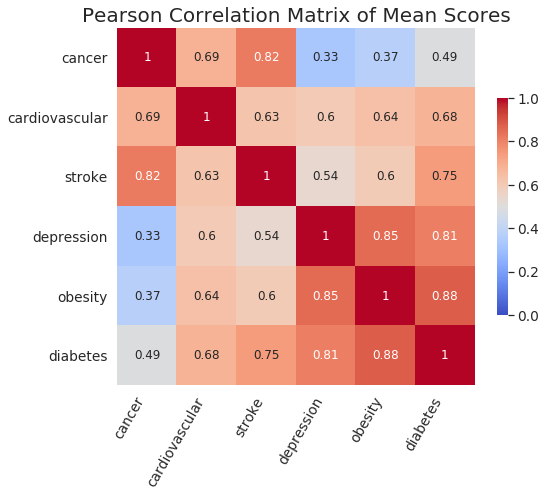

In [14]:
# Create a correlation / heat map

sns.set(font_scale=1.25)
# Create a correlation matrix of means
corr = yearMeanDf.corr(method='pearson')

# Seaborn heatmap
plt.figure(figsize=(8,8))
ax = sns.heatmap(
    corr, 
    vmin=0, vmax=1, center=0.5,
    cmap='coolwarm',
    square=True,
    robust=True,
    annot=True,
    annot_kws={"size":12},
    cbar_kws={"shrink": 0.5}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=60,
    horizontalalignment='right'
);

plt.title('Pearson Correlation Matrix of Mean Scores', fontdict = {'fontsize' : 20})

The strongest correlation among the health queries was 0.88 between obesity and diabetes, which makes sense because people who are obese are at a high rist of getting Type 2 diabetes. The next strongest correlation was 0.85 between obesity and depression. People with obesity have a higher chance of being depressed. The intertwined nature of obesity and depression is still being studied, medical professionals are unsure if the relationship might be bidirectional, meaning that depression could potentially cause obesity in some cases (https://www.medicalnewstoday.com/articles/323668).

In [0]:
# Melt dataframe to have only columns 'region', 'year', and 'value'; id_vars='region', var_name='year' 
melted = pd.melt(yearMeanDf, id_vars='Year', var_name='Query', value_name='Mean')
melted.Year = pd.to_numeric(melted.Year)
#melted.head()

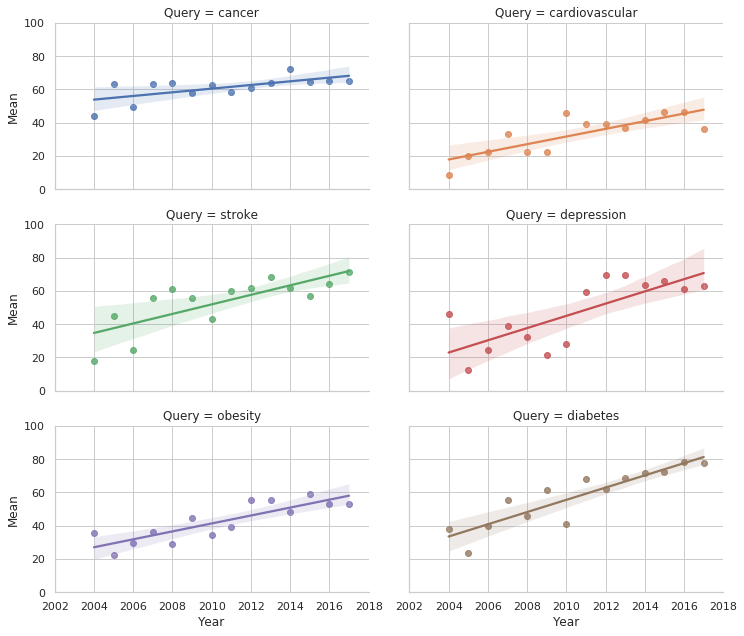

In [16]:
# Create subplots of mean interest score for each health query
sns.set(font_scale=1)
sns.set_style('whitegrid')
p = sns.lmplot(x='Year', y='Mean', hue='Query', data=melted,
            height=3, aspect=1.75, col_wrap=2, col='Query')

p.set(xlim = (2002,2018))
p.set(ylim = (0,100))
plt.tight_layout()


The line of best fit is plotted above for each of the health queries in order to visualize how quickly the mean search scores are increasing. While the mean search interest score for every query has increased, ‘diabetes’, ‘depression’ and ‘stroke’ have the highest rate of increase from 2004-2017 because their lines have the steepest slope. To verify this, a regression model can be fit to the data and then the rates of increase can be compared more accurately. 

However, it is an assumption that the mean search scores are linear. Different models should be tested to verify which model would be best for each data set. When considering year-to-year changes, search interest score for depression shows the greatest fluctuations and in fact, does not look linear. 
 


In [17]:
# Regional mean search count per city
region_mean = healthSearchData_nozeros.groupby('region').mean()
region_mean

,2004+cancer,2004+cardiovascular,2004+stroke,2004+depression,2004+rehab,2004+vaccine,2004+diarrhea,2004+obesity,2004+diabetes,2005+cancer,2005+cardiovascular,2005+stroke,2005+depression,2005+rehab,2005+vaccine,2005+diarrhea,2005+obesity,2005+diabetes,2006+cancer,2006+cardiovascular,2006+stroke,2006+depression,2006+rehab,2006+vaccine,2006+diarrhea,2006+obesity,2006+diabetes,2007+cancer,2007+cardiovascular,2007+stroke,2007+depression,2007+rehab,2007+vaccine,2007+diarrhea,2007+obesity,2007+diabetes,2008+cancer,2008+cardiovascular,2008+stroke,2008+depression,...,2013+vaccine,2013+diarrhea,2013+obesity,2013+diabetes,2014+cancer,2014+cardiovascular,2014+stroke,2014+depression,2014+rehab,2014+vaccine,2014+diarrhea,2014+obesity,2014+diabetes,2015+cancer,2015+cardiovascular,2015+stroke,2015+depression,2015+rehab,2015+vaccine,2015+diarrhea,2015+obesity,2015+diabetes,2016+cancer,2016+cardiovascular,2016+stroke,2016+depression,2016+rehab,2016+vaccine,2016+diarrhea,2016+obesity,2016+diabetes,2017+cancer,2017+cardiovascular,2017+stroke,2017+depression,2017+rehab,2017+vaccine,2017+diarrhea,2017+obesity,2017+diabetes
region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Midwest,45.588235,9.500000,16.980392,51.392157,17.755102,32.346939,18.549020,37.571429,39.156863,65.764706,20.647059,44.941176,13.078431,22.627451,28.160000,25.958333,23.560000,22.980392,51.274510,23.530612,25.568627,26.549020,30.549020,40.140000,44.940000,32.380000,40.235294,65.568627,34.440000,57.647059,43.117647,31.078431,44.235294,21.098039,41.060000,58.000000,65.764706,21.755102,59.274510,34.745098,...,64.254902,70.686275,61.300000,70.509804,74.490196,41.647059,62.725490,66.862745,55.941176,63.784314,70.647059,50.940000,73.333333,66.588235,48.039216,58.156863,70.254902,52.509804,65.352941,72.215686,63.860000,73.647059,66.235294,46.176471,64.705882,64.607843,44.823529,66.274510,75.058824,56.600000,78.490196,66.686275,35.294118,71.725490,66.568627,47.352941,74.784314,77.098039,56.600000,77.647059
Northeast,46.304348,7.800000,17.739130,48.347826,21.739130,42.409091,16.454545,39.826087,35.521739,68.391304,18.500000,47.304348,12.521739,25.782609,33.521739,27.409091,22.782609,22.565217,51.869565,21.590909,23.782609,25.826087,32.272727,44.521739,42.954545,30.652174,37.782609,67.956522,28.500000,53.565217,42.304348,37.826087,43.217391,20.695652,37.173913,53.173913,70.695652,20.045455,61.913043,34.739130,...,68.826087,68.217391,59.217391,69.217391,78.608696,38.695652,62.521739,69.347826,65.782609,66.869565,66.826087,52.173913,70.304348,69.217391,41.782609,59.260870,70.826087,61.782609,70.304348,71.913043,63.130435,72.521739,70.782609,42.086957,65.304348,65.565217,57.260870,68.434783,73.521739,57.608696,78.347826,70.043478,32.434783,69.391304,68.086957,58.826087,81.217391,73.000000,55.956522,76.347826
South,43.816092,8.693333,17.569767,42.298851,21.845238,32.674699,17.307692,34.190476,39.436782,62.517241,22.493827,45.390805,11.045977,28.246914,30.558140,27.700000,22.141176,24.080460,48.551724,25.083333,23.218391,22.206897,35.430233,37.376471,42.682353,29.209302,40.689655,63.229885,36.988372,55.793103,36.298851,38.413793,40.298851,21.546512,34.093023,56.747126,63.827586,25.344828,60.333333,29.494253,...,61.183908,69.965517,53.209302,69.942529,72.977011,46.701149,61.080460,60.747126,65.482759,58.954023,70.126437,45.372093,71.965517,65.034483,50.988506,56.080460,62.770115,61.954023,56.195402,70.000000,56.686047,73.172414,65.712644,51.241379,63.298851,58.827586,57.954023,59.287356,73.022989,50.395349,79.505747,64.551724,41.045977,71.712644,60.264368,60.712644,69.149425,73.080460,50.755814,79.091954
West,41.183673,7.243902,19.166667,45.166667,16.565217,34.565217,16.911111,34.800000,36.333333,58.061224,14.200000,43.425532,13.645833,20.595745,28.829787,24.717391,20.326087,22.791667,47.000000,17.600000,26.625000,24.750000,24.297872,38.382979,41.425532,26.673913,37.437500,58.229167,26.333333,55.000000,38.520833,30.000000,39.127660,18.191489,33.760870,50.085

In [0]:
# Find the mean number of searches per year for each region
# mean_dict dictionary, keys = disease, year

mean_dict = {}
for col in region_mean.columns:
    if '+' in col:
        year = col.split('+')[0]
        disease = col.split('+')[-1]
        if not disease in mean_dict:
            mean_dict[disease] = {}
        if not year in mean_dict[disease]:
            mean_dict[disease][year] = region_mean[col]

In [19]:
print(mean_dict.keys())
print(mean_dict['cancer'].keys())
print(mean_dict['cancer']['2005'].keys())

dict_keys(['cancer', 'cardiovascular', 'stroke', 'depression', 'rehab', 'vaccine', 'diarrhea', 'obesity', 'diabetes'])
dict_keys(['2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017'])
Index(['Midwest', 'Northeast', 'South', 'West'], dtype='object', name='region')


In [20]:
mean_dict['cancer']['2004'].values

array([45.58823529, 46.30434783, 43.81609195, 41.18367347])

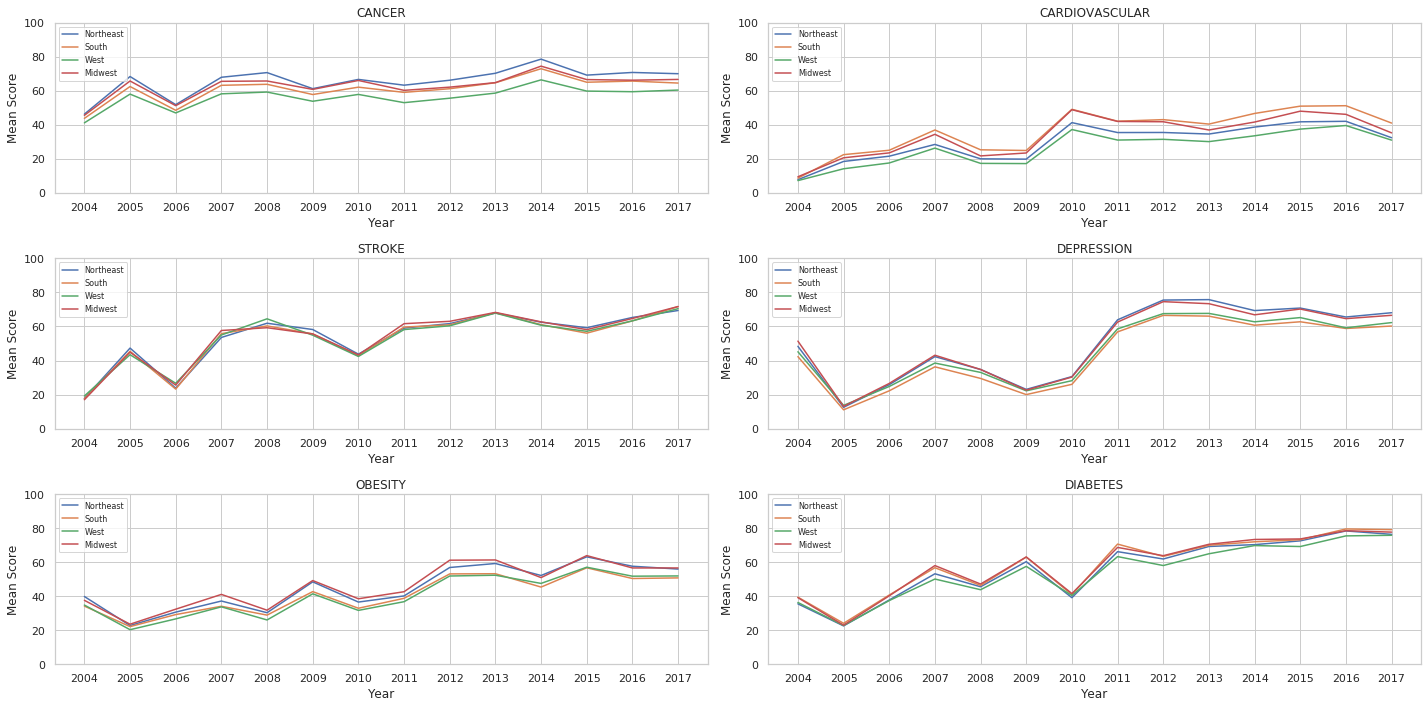

In [21]:
# Mean score trend by region and query
# Create a loop for 3 x 2 subplots - create 1 line plot per query
sns.set(font_scale=1)
sns.set_style('whitegrid')
fig = plt.figure(figsize=(20,10))

for ind in range(len(queries)):
    df = pd.DataFrame(mean_dict[queries[ind]]).T
    df = df[['Northeast', 'South', 'West', 'Midwest']]
    
    fig.add_subplot(3,2,ind+1)
    ax = plt.plot(df)
    plt.title(queries[ind].upper())
    plt.xlabel('Year')
    plt.ylabel('Mean Score')
    plt.ylim(0,100)
    plt.legend(df.columns, fontsize=8, loc='upper left')

plt.tight_layout()


# Student t-test to compare means

Does the Northeast have a significantly higher interest than the West in cancer? To determine whether or not there was a significant difference, a one-tailed Student t-test was used to compare the means. The null hypothesis ( H0 ) was that the mean interest score for cancer in the Northeast  ≤  mean interest score in the West, and the alternative hypothesis ( H1 ) is that the Northeast has a significantly higher mean interest score than the West.

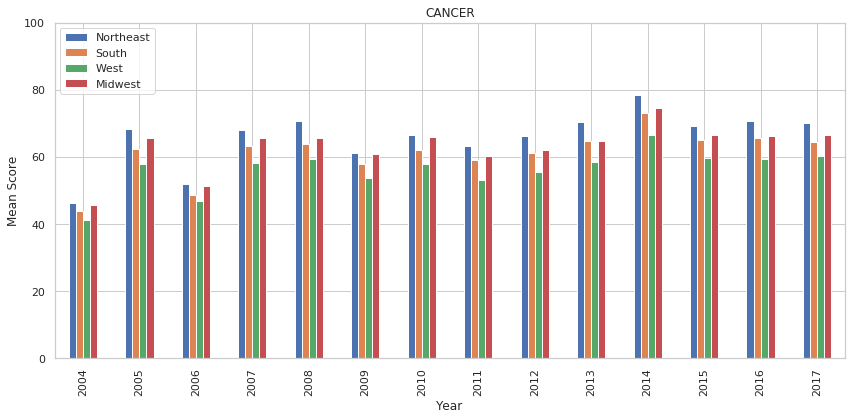

In [22]:
df = pd.DataFrame(mean_dict['cancer']).T
df = df[['Northeast', 'South', 'West', 'Midwest']]
    
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,1,1)
df.plot(kind='bar', ax=ax)
plt.title('CANCER')
plt.xlabel('Year')
plt.ylabel('Mean Score')
plt.ylim(0,100)
plt.legend(df.columns, fontsize=11, loc='upper left')

plt.tight_layout()

In [0]:
# Create 'cancer' search dataframe with columns for year, count, region.  
# Also creates years list
cancer_all = pd.DataFrame()
years = []
for col in healthSearchData.columns:
    if '+' and 'cancer' in col:
        year = col.split('+')[0]
        years.append(year)
        add_col = healthSearchData[col] 
        cancer_all = pd.concat([cancer_all, add_col], axis=1)

# Rename columns with years only
cancer_all.columns = years
# Add 'region' column
cancer_all['region'] = healthSearchData['region']

# Melt dataframe to have only columns 'region', 'year', and 'value'
melted_cancer = pd.melt(cancer_all, id_vars='region', var_name='year' )

In [24]:
melted_cancer.head()

,region,year,value
0,Northeast,2004,44
1,Northeast,2004,47
2,Northeast,2004,48
3,South,2004,44
4,Northeast,2004,52


In [25]:
cancer_all.head()

,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,region
0,44,70,55,70,68,61,65,65,67,71,79,67,69,70,Northeast
1,47,63,49,64,64,58,62,56,58,64,71,64,68,70,Northeast
2,48,62,54,61,65,58,64,60,62,68,80,64,74,68,Northeast
3,44,55,44,65,66,53,62,59,59,62,72,66,63,53,South
4,52,73,57,72,75,65,70,66,69,75,81,71,74,75,Northeast


In [0]:
northeast = melted_cancer[melted_cancer.region == 'Northeast']
west = melted_cancer[melted_cancer.region == 'West']

In [27]:
# Sample sizes are large
print(len(northeast.value))
print(len(west.value))

322
686


In [28]:
# Variances are about equal
print(np.var(northeast.value))
print(np.var(west.value))

85.90355310366111
85.27925439230242


Hypothesis testing: Is the mean Northeast interest score significantly greater than the mean West interest score?  
H0: mean NE <= mean West  
H1: mean NE > mean West

In [30]:
# Variances are equal, default equal_var = True
tstat, pval = ttest_ind(northeast.value, west.value)
print('t-stat =', tstat, 'p-value =', pval/2) #Since only using one tail, 
# and ttest_ind is by default a 2 tail test, find 1/2 the p-value

t-stat = 15.293615834714913 p-value = 6.224181771101961e-48


The p-value is 6.22e-48 which means that there is a very small probability close to zero that we would get the average scores under the condition of the null hypothesis. Therefore, when considering all years, the Northeast is significantly more interested in cancer queries than the West is.

In the following section, a Welch's t-test is performed for each year to determine if the Northeast is significantly more interested in cancer queries than the West for each year. Is the mean Northeast interest score significantly different than the mean West interest score for each year?

For each year test H0: mean NE <= mean West   
H1: mean NE > mean West

In [0]:
# Variances are not equal within years, so Welch's t-test performed here

welch_df = pd.DataFrame(index=years, columns=['Northeast_n', 'Northeast_var', 'West_n', 'West_var', 't-stat', 'p-value'])

for year in years:
    ne = northeast[northeast.year == year]
    w = west[west.year == year]
    #print(year)
    #print('Northeast: n =', len(ne), 'var =', np.var(ne.value))
    #print('West: n =', len(w), 'var =', np.var(w.value))
    tstat, pval = ttest_ind(ne.value, w.value, equal_var=False)
    #print('t-stat =', tstat, 'p-value =', pval/2)
    welch_df.loc[year] = [len(ne), np.var(ne.value),
                          len(w), np.var(w.value),
                          tstat, pval/2]

In [32]:
welch_df

,Northeast_n,Northeast_var,West_n,West_var,t-stat,p-value
2004,23,25.5161,49,40.2316,3.62269,0.000328056
2005,23,21.8904,49,49.8126,7.24534,4.28741e-10
2006,23,24.7221,49,114.694,2.598,0.00571193
2007,23,46.3894,49,135.549,4.91491,3.08172e-06
2008,23,40.1248,49,62.399,6.46719,1.70254e-08
2009,23,30.3667,49,41.8776,4.9328,4.76992e-06
2010,23,31.7769,49,56.9238,5.43715,6.20331e-07
2011,23,14.7335,49,23.0187,9.57387,2.09237e-13
2012,23,17.5614,49,20.3898,9.55262,9.11211e-13
2013,23,17.8639,49,21.696,10.3634,5.42147e-14


All p-values are less than 0.05, therefore we can reject the null hypothesis. A p-value less than 0.05 means that there is less than a 5% chance that given the condition of the null hypothesis that the Northeast has a mean interest score less than or equal to the mean interest score in the West for cancer, there is less than a 5% chance that we would obtain the means that are in our data from a random sample.